In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

### Attributes information
- Jumlah Kolom: 17

    - Invoice id: Computer generated sales slip invoice identification number

    - Branch: Branch of supercenter (3 branches are available identified by A, B and C).

    - City: Location of supercenters

    - Customer type: Type of customers, recorded by Members for customers using member card and Normal for without member card.

    - Gender: Gender type of customer

    - Product line: General item categorization groups - Electronic accessories, Fashion accessories, Food and beverages, Health and beauty, Home and lifestyle, Sports and travel

    - Unit price: Price of each product in $

    - Quantity: Number of products purchased by customer

    - Tax: 5% tax fee for customer buying

    - Total: Total price including tax -> <b>Unit price * Quantity * 1.05</b>

    - Date: Date of purchase (Record available from January 2019 to March 2019)

    - Time: Purchase time (10am to 9pm)

    - Payment: Payment used by customer for purchase (3 methods are available – Cash, Credit card and Ewallet)

    - COGS: Cost of goods sold -> <b>Unit price * Quantity</b>

    - Gross margin percentage: Gross margin percentage <b> -> (Total - cogs / Total) * 100%</b>

    - Gross income: Gross income -> <b>Total - cogs</b>

    - Rating: Customer stratification rating on their overall shopping experience (On a scale of 1 to 10)

### Latar Belakang:
- Jumlah gross income menurun di bulan Februari dan meningkat pada bulan Maret, tetapi tidak lebih besar dari bulan Januari 
- Rating tiap cabang kecil (rata-ratanya kecil) sehingga di search engine tidak masuk rekomendasi

### Tujuan:
- Untuk meningkatkan Gross Income dan Rating per bulan. <b>Target Variable: Gross Income dan Rating</b>
- Melakukan analisa Gross Income dan Rating dengan segmentasi Product line, City (Branch) dan Customer Type
- Evaluasi kondisi eksisting perbulan di setiap cabang

## 1) Membaca Data dan Membuat Kolom Baru

In [2]:
df = pd.read_csv('./module-2/supermarket_sales.csv', parse_dates=['Date', 'Time'])

# Menambah kolom baru
df['Tanggal'] = df['Date'].apply(lambda x: x.strftime('%-d'))
df['Month'] = df['Date'].apply(lambda x: x.strftime('%B'))
df['Year'] = df['Date'].apply(lambda x: x.strftime('%Y'))
df['Day'] = df['Date'].apply(lambda x: x.strftime('%A'))
df['Day_'] = df['Date'].apply(lambda x: x.strftime('%w'))
df['Month_'] = df['Date'].apply(lambda x: x.strftime('%-m'))
df['Jam'] = df['Time'].apply(lambda x: x.strftime('%-H'))

df["Tanggal"] = pd.to_numeric(df["Tanggal"])
# df.astype({'Tanggal': 'int64'})
# Mengubah Urutan Kolom
new_col = ['Invoice ID',  'Date', 'Tanggal', 'Month', 'Year', 'Day', 'Day_', 'Month_',
           'Time', 'Jam','Branch', 'City', 'Customer type', 'Gender','Product line',
           'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating']
df = df[new_col]
df.head()

,Invoice ID,Date,Tanggal,Month,Year,Day,Day_,Month_,Time,Jam,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,2019-01-05,5,January,2019,Saturday,6,1,2020-07-16 13:08:00,13,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,2019-03-08,8,March,2019,Friday,5,3,2020-07-16 10:29:00,10,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,2019-03-03,3,March,2019,Sunday,0,3,2020-07-16 13:23:00,13,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,2019-01-27,27,January,2019,Sunday,0,1,2020-07-16 20:33:00,20,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,2019-02-08,8,February,2019,Friday,5,2,2020-07-16 10:37:00,10,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3


In [3]:
df.tail()

,Invoice ID,Date,Tanggal,Month,Year,Day,Day_,Month_,Time,Jam,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating
995,233-67-5758,2019-01-29,29,January,2019,Tuesday,2,1,2020-07-16 13:46:00,13,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,2019-03-02,2,March,2019,Saturday,6,3,2020-07-16 17:16:00,17,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,2019-02-09,9,February,2019,Saturday,6,2,2020-07-16 13:22:00,13,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,2019-02-22,22,February,2019,Friday,5,2,2020-07-16 15:33:00,15,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,Cash,65.82,4.761905,3.2910,4.1
999,849-09-3807,2019-02-18,18,February,2019,Monday,1,2,2020-07-16 13:28:00,13,A,Yangon,Member,Female,Fashion accessories,88.34,7,30.9190,649.2990,Cash,618.38,4.761905,30.9190,6.6


In [4]:
df.columns

Index(['Invoice ID', 'Date', 'Tanggal', 'Month', 'Year', 'Day', 'Day_',
       'Month_', 'Time', 'Jam', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Payment',
       'cogs', 'gross margin percentage', 'gross income', 'Rating'],
      dtype='object')

In [5]:
df.shape

(1000, 24)

In [6]:
# Detect Missing Value
df.isnull().sum()

Invoice ID                 0
Date                       0
Tanggal                    0
Month                      0
Year                       0
Day                        0
Day_                       0
Month_                     0
Time                       0
Jam                        0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Invoice ID               1000 non-null   object        
 1   Date                     1000 non-null   datetime64[ns]
 2   Tanggal                  1000 non-null   int64         
 3   Month                    1000 non-null   object        
 4   Year                     1000 non-null   object        
 5   Day                      1000 non-null   object        
 6   Day_                     1000 non-null   object        
 7   Month_                   1000 non-null   object        
 8   Time                     1000 non-null   datetime64[ns]
 9   Jam                      1000 non-null   object        
 10  Branch                   1000 non-null   object        
 11  City                     1000 non-null   object        
 12  Customer type            1000 non-n

## 2) Mencari Unique Value dari setiap Kolom bertipe Objek

In [8]:
df.nunique()

Invoice ID                 1000
Date                         89
Tanggal                      31
Month                         3
Year                          1
Day                           7
Day_                          7
Month_                        3
Time                        506
Jam                          11
Branch                        3
City                          3
Customer type                 2
Gender                        2
Product line                  6
Unit price                  943
Quantity                     10
Tax 5%                      990
Total                       990
Payment                       3
cogs                        990
gross margin percentage       1
gross income                990
Rating                       61
dtype: int64

In [9]:
df['Invoice ID'].unique()

array(['750-67-8428', '226-31-3081', '631-41-3108', '123-19-1176',
       '373-73-7910', '699-14-3026', '355-53-5943', '315-22-5665',
       '665-32-9167', '692-92-5582', '351-62-0822', '529-56-3974',
       '365-64-0515', '252-56-2699', '829-34-3910', '299-46-1805',
       '656-95-9349', '765-26-6951', '329-62-1586', '319-50-3348',
       '300-71-4605', '371-85-5789', '273-16-6619', '636-48-8204',
       '549-59-1358', '227-03-5010', '649-29-6775', '189-17-4241',
       '145-94-9061', '848-62-7243', '871-79-8483', '149-71-6266',
       '640-49-2076', '595-11-5460', '183-56-6882', '232-16-2483',
       '129-29-8530', '272-65-1806', '333-73-7901', '777-82-7220',
       '280-35-5823', '554-53-8700', '354-25-5821', '228-96-1411',
       '617-15-4209', '132-32-9879', '370-41-7321', '727-46-3608',
       '669-54-1719', '574-22-5561', '326-78-5178', '162-48-8011',
       '616-24-2851', '778-71-5554', '242-55-6721', '399-46-5918',
       '106-35-6779', '635-40-6220', '817-48-8732', '120-06-42

In [10]:
df['Branch'].unique()

array(['A', 'C', 'B'], dtype=object)

In [11]:
df['City'].unique()

array(['Yangon', 'Naypyitaw', 'Mandalay'], dtype=object)

In [12]:
df['Customer type'].unique()

array(['Member', 'Normal'], dtype=object)

In [13]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [14]:
df['Product line'].unique()

array(['Health and beauty', 'Electronic accessories',
       'Home and lifestyle', 'Sports and travel', 'Food and beverages',
       'Fashion accessories'], dtype=object)

In [15]:
df['Payment'].unique()

array(['Ewallet', 'Cash', 'Credit card'], dtype=object)

## 3) Mendeskripsikan Data

In [16]:
dfdesc = df.describe().T
dfdesc['iqr'] = dfdesc['75%'] - dfdesc['25%']
dfdesc.T

,Tanggal,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,15.256000,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,8.693563,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,1.000000,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,8.000000,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,15.000000,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,23.000000,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,31.000000,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000
iqr,15.000000,45.060000,5.000000,16.520375,346.927875,330.40750,0.000000,16.520375,3.00000


### Grafik Korelasi Heatmap
- Target Variable:
    1. Rating memiliki korelasi yang sangat kecil terhadap semua feature (korelasi sangat lemah)
    2. Gross Income memiliki korelasi yang cukup kuat dengan Unit Price dan Quantity sehingga hal yang harus diperbaiki adalah Unit Price dan Quantity
        - Selanjutnya akan dilakukan analisa dengan Feature tersebut

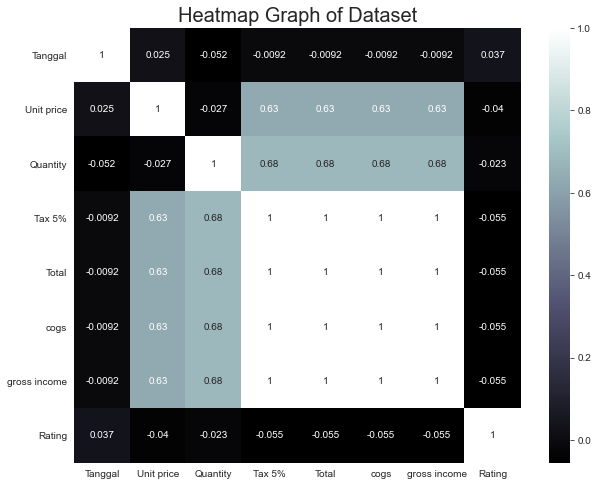

In [17]:
plt.figure(figsize=(10, 8))
dftemp = df[df['City'] == 'Yangon'].drop(columns=['gross margin percentage'])
sns.heatmap(dftemp.corr(), cmap='bone', annot=True)
plt.title('Heatmap Graph of Dataset', fontsize=20)
plt.savefig('1-heatmap.png')

## 3) Univariate Data Analysis

### Grafik Distribusi Gross Income membentuk grafik distribusi Normal: Positive Skewness. 
- Nilai Median Gross Income lebih mewakili  dibanding nilai Mean.
- Oleh karena itu, Supermarket ini memiliki Gross Income sebesar nilai Median.

<i>**source: "..if the distribution is highly skewed, the mean should not be used to represent the data." - Lind, Douglas A., William G. Marchal, and Samuel Adam Wathen. Statistical Techniques in Business & Economics. Boston: McGraw-Hill/Irwin, 2008.</i>

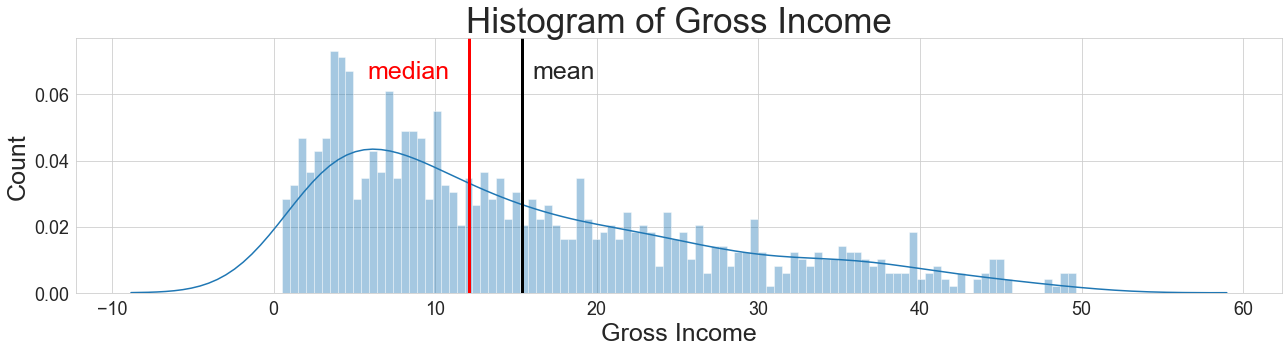

In [18]:
plt.figure(figsize=(18, 5))
sns.distplot(df['gross income'], bins=100)
plt.title('Histogram of Gross Income', fontsize=35)
plt.ylabel('Count', fontsize=25)
plt.xlabel('Gross Income', fontsize=25)
plt.text(16, 0.065, 'mean', fontsize=25)
plt.axvline(x=df['gross income'].mean(), linewidth=3, color = 'k') 
plt.text(5.8, 0.065, 'median', fontsize=25, color='r')
plt.axvline(x=df['gross income'].median(), linewidth=3, color = 'r')  
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('hist-1.png')
plt.show()

### Grafik Distribusi Rating membentuk grafik distribusi Normal yang mendekati simetris
- Nilai Mean dan Median hampir sama dan dapat mewakili nilai tengah dari feature Rating
- Oleh karena itu, Rating yang diperoleh supermarket berkisar nilai Mean-nya

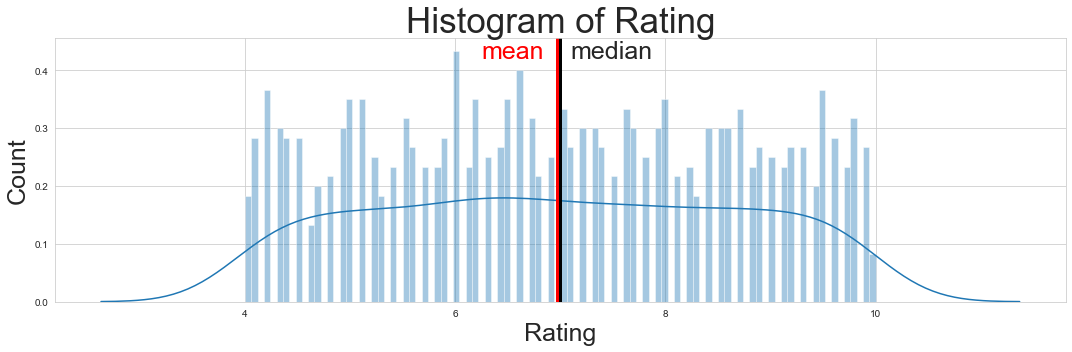

In [19]:
plt.figure(figsize=(15, 5))
sns.distplot(df['Rating'], bins=100)
plt.title('Histogram of Rating', fontsize=35)
plt.ylabel('Count', fontsize=25)
plt.xlabel('Rating', fontsize=25)
plt.axvline(x=df['Rating'].mean(), linewidth=3, color = 'r') 
plt.axvline(x=df['Rating'].median(), linewidth=3, color = 'k') 
plt.text(7.1, 0.42, 'median', fontsize=25)
plt.text(6.25, 0.42, 'mean', fontsize=25, color='r')
plt.tight_layout()
plt.savefig('hist-2.png')
plt.show()

## 4) Multivariate Data Analysis

##  <font color='brown'>a) GROSS INCOME</font> 

### Grafik Pie Persentase Gross Income di setiap Cabang
- Cabang Naypyitaw menghasilkan Gross Income yang paling banyak dalam 3 bulan pertama, disusul oleh Gross Income dari Yangon dan Mandalay.

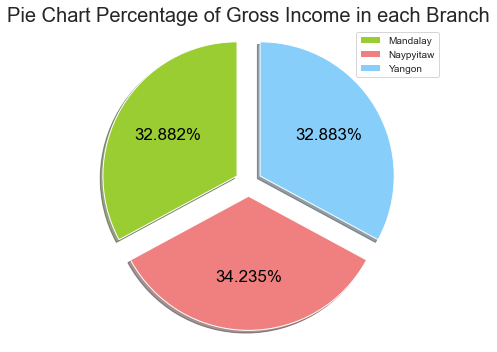

In [20]:
df_total_per_branch = df.pivot_table(index=['City'], values='gross income', aggfunc=['sum', 'mean', 'median'])
df_total_per_branch['Percentage Total'] = (df_total_per_branch['sum']/df_total_per_branch['sum'].sum()) * 100
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(7, 5))
patches = plt.pie(
    df_total_per_branch['Percentage Total'], 
    colors=colors,
    startangle=90, 
    shadow=True, 
    textprops={
    'size': 17,
    'color': 'black'
    },
    autopct='%.3f%%', 
    explode=(0.1, 0.1, 0.1)
)
plt.legend(patches, labels=df_total_per_branch.index, loc='upper right')
plt.axis('equal')
plt.title('Pie Chart Percentage of Gross Income in each Branch', fontsize=20)
plt.tight_layout()
plt.show()

### Jumlah Gross Income per bulan di setiap City
- Jumlah Gross income menurun di bulan Februari dan meningkat di bulan Maret di setiap kota, tetapi tidak melebihi bulan Januari

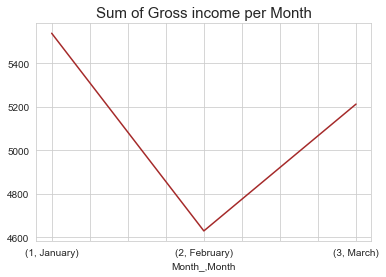

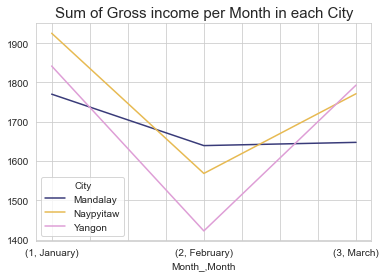

In [21]:
df.groupby(['Month_', 'Month'])['gross income'].sum().plot(color='brown') 
plt.title('Sum of Gross income per Month', fontsize=15)

df.groupby(['City', 'Month_', 'Month'])['gross income'].sum().unstack('City').plot(colormap='tab20b')#['#9ACD33','#F18080','#ACDDFA']) 
plt.title('Sum of Gross income per Month in each City', fontsize=15)
# cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
# plt.savefig('2-grossincome.png')
# plt.savefig('3-grossincome2.png')
plt.show()
#ACDDFA Yangon
#F18080 Nay
#9ACD33 Mandalay


### Gross Income per tanggal di setiap Cabang
- Grafik gross income di semua kota sama-sama menurun paling rendah pada setiap tanggal 13, 18, 21 dan 31
- Gross Income per tanggal memiliki fluktuasi di setiap cabang

In [22]:
temp = df.pivot_table(index=['Tanggal', 'City'], values=['gross income'], aggfunc='sum').unstack('City')
temp['sum'] = temp[('gross income',  'Mandalay')] + temp[('gross income', 'Naypyitaw')] + temp[('gross income', 'Yangon')]
temp = temp.reset_index()
temp.columns = ['Tanggal', 'Mandalay', 'Naypyitaw', 'Yangon', 'Jumlah Gross Income']
# temp
temp_2 = temp.melt('Tanggal', var_name='Kota',  value_name='Jumlah Gross Income')
temp_2

,Tanggal,Kota,Jumlah Gross Income
0,1,Mandalay,117.6195
1,2,Mandalay,302.1115
2,3,Mandalay,184.1875
3,4,Mandalay,83.1880
4,5,Mandalay,238.8765
5,6,Mandalay,196.3205
6,7,Mandalay,207.7680
7,8,Mandalay,193.1885
8,9,Mandalay,200.9585
9,10,Mandalay,113.2485


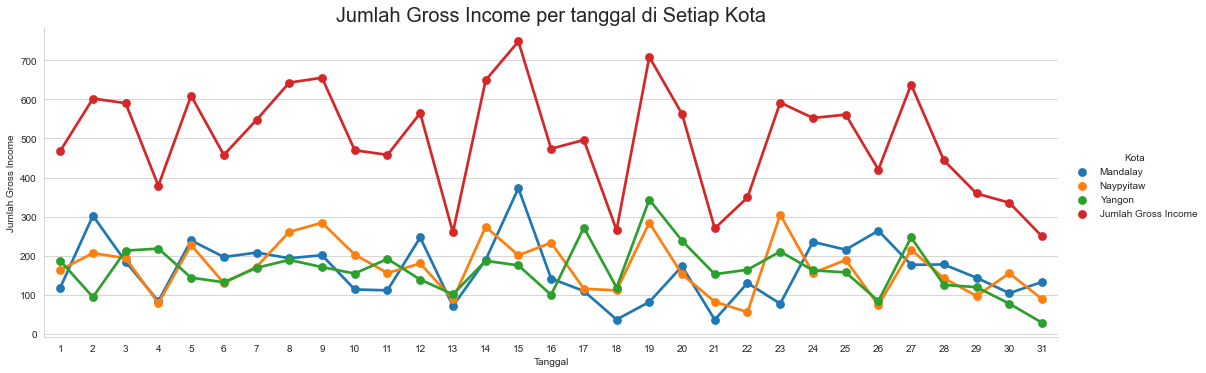

In [23]:
g = sns.factorplot(x="Tanggal", y="Jumlah Gross Income", hue='Kota', data=temp_2, size=5, aspect=3)
plt.title('Jumlah Gross Income per tanggal di Setiap Kota', fontsize=20)
# # plt.savefig('5-givssemuakotavstgl.png')
plt.show()

### Grafik Boxplot Gross Income per Hari
- Per Hari
    - 50% persebaran Gross Income paling besar dihasilkan di hari Selasa (memiliki IQR yang paling besar)
    - Nilai median yang paling besar ada pada hari Sabtu dan Minggu
- Per Kota
    - 50% persebaran Gross income dihasilkan di hari Jumat di Naypyitaw (memiliki IQR yang paling besar)

*source: "Bagian utama boxplot adalah kotak berbentuk persegi (Box) yang merupakan bidang yang menyajikan interquartile range (IQR), dimana 50% dari nilai data pengamatan terletak di sana." - https://smartstat.wordpress.com/2010/11/03/mengenal-box-plot-box-and-whisker-plots/

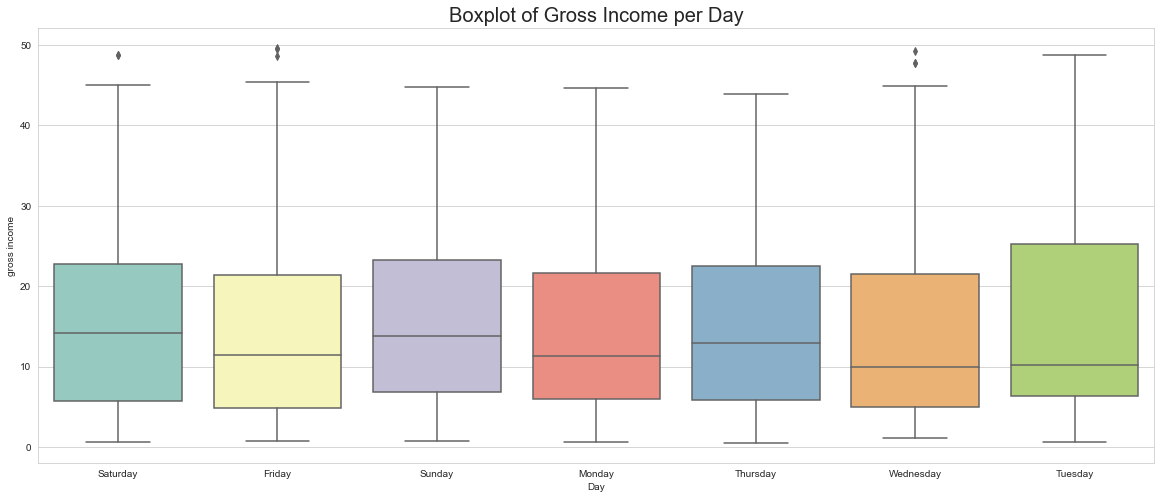

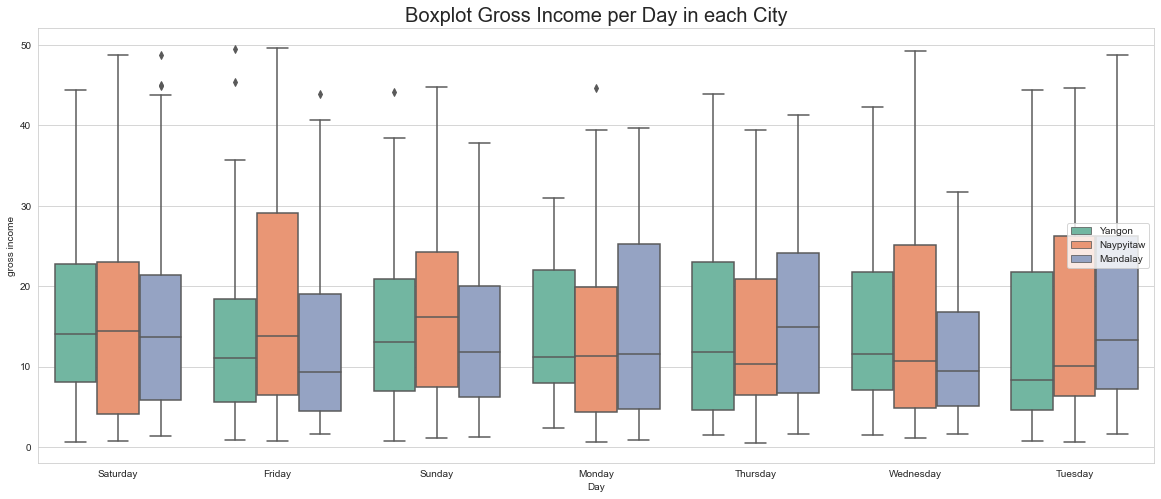

In [24]:
plt.figure(figsize=(20, 8))
df_day_gross = df[['Day', 'gross income']]
ax = sns.boxplot(x="Day", y="gross income", data=df_day_gross, palette="Set3")
plt.title("Boxplot of Gross Income per Day", fontsize=20)
plt.savefig('6-giboxplotvsday.png')
plt.figure(figsize=(20, 8))
plt.grid(True)
ax = sns.boxplot(x="Day", y="gross income", hue='City', data=df, palette="Set2")
plt.title('Boxplot Gross Income per Day in each City', fontsize=20)
plt.legend(loc='right')
plt.savefig('7-giboxplotvsdayvscity.png')
plt.show()
#, order=df['Day'])

### Jumlah dari Gross Income per City tiap Jam
- Cabang Mandalay:
    - Gross Income tertinggi: jam 19:00
    - Gross Income terendah: jam 16:00
- Cabang Naypyitaw
    - Gross Income tertinggi: jam 13:00 dan 19:00
    - Gross Income terendah: jam 11:00 dan 12:00
- Cabang Yangon
    - Gross Income tertinggi: jam 13:00 dan 19:00
    - Gross Income terendah: jam 20:00

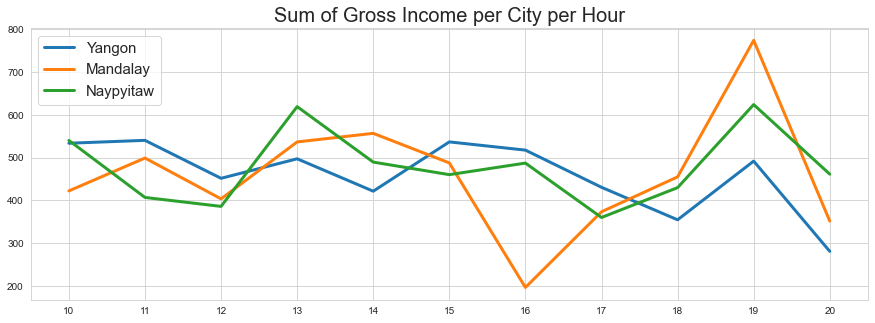

In [25]:
df_bcj = df.pivot_table(index=['Branch', 'City', 'Jam'], values='gross income', aggfunc='sum').unstack(['Branch', 'City'])
yangon = df_bcj[('gross income', 'A', 'Yangon')]
mandalay = df_bcj[('gross income', 'B', 'Mandalay')]
naypyitaw = df_bcj[('gross income', 'C', 'Naypyitaw')]
jam = df_bcj.index
plt.figure(figsize=(15, 5))
plt.plot(jam, yangon, jam, mandalay, jam, naypyitaw, linewidth=3)
plt.legend(['Yangon', 'Mandalay', 'Naypyitaw'], loc='upper left', prop={'size': 15})
plt.title('Sum of Gross Income per City per Hour', fontsize=20)
# plt.savefig('10-givscityvshour.png')
plt.show()

### Grafik Rata-rata Gross Income di setiap cabang pada tiap waktu dalam rentang 2 jam
- Median Gross Income menurun dari rentang jam 13 - 15 ke rentang jam 16 - 18 (dari siang ke sore)

In [26]:
# Membuat kolom 'Jam' dengan function jam2 
def jam2(x):
    """
        Rentang 2 jam
    """
    if '10' <= x <= '12':
        return 'Jam 10 - 12'
    elif '13' <= x <= '15':
        return 'Jam 13 - 15'
    elif '16' <= x <= '18':
        return 'Jam 16 - 18'
    else:
        return 'Jam 19 - 21'
    
df['Jam_temp'] = df['Jam'].apply(jam2)
df.head()

,Invoice ID,Date,Tanggal,Month,Year,Day,Day_,Month_,Time,Jam,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating,Jam_temp
0,750-67-8428,2019-01-05,5,January,2019,Saturday,6,1,2020-07-16 13:08:00,13,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1,Jam 13 - 15
1,226-31-3081,2019-03-08,8,March,2019,Friday,5,3,2020-07-16 10:29:00,10,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6,Jam 10 - 12
2,631-41-3108,2019-03-03,3,March,2019,Sunday,0,3,2020-07-16 13:23:00,13,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4,Jam 13 - 15
3,123-19-1176,2019-01-27,27,January,2019,Sunday,0,1,2020-07-16 20:33:00,20,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4,Jam 19 - 21
4,373-73-7910,2019-02-08,8,February,2019,Friday,5,2,2020-07-16 10:37:00,10,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3,Jam 10 - 12


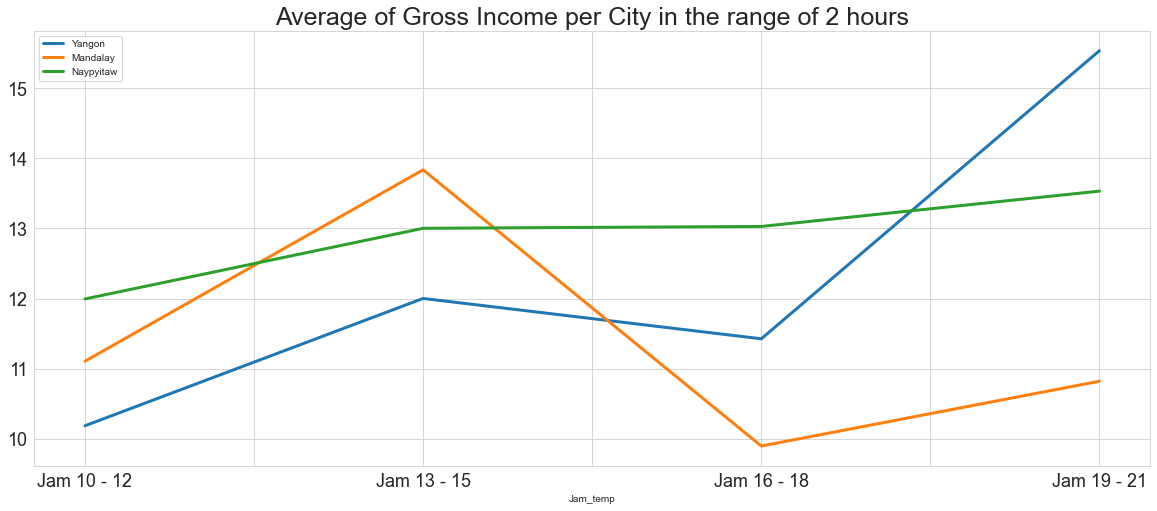

In [27]:
# Rata-rata gross income tiap City per rentang 2 jam
plt.figure(figsize=(20, 8))
df.groupby(['City', 'Jam_temp'])['gross income'].median()['Yangon'].plot(linewidth=3)
df.groupby(['City', 'Jam_temp'])['gross income'].median()['Mandalay'].plot(linewidth=3)
df.groupby(['City', 'Jam_temp'])['gross income'].median()['Naypyitaw'].plot(linewidth=3).legend(['Yangon', 'Mandalay', 'Naypyitaw'])
plt.title('Average of Gross Income per City in the range of 2 hours', fontsize=25)
plt.tick_params(labelsize=18)
plt.savefig('12-givscity2hr.png')
plt.show()

### Boxplot dan Violinplot Gross Income per Hari pada setiap Gender
- Pada hari Jumat: Ada Pria yang berbelanja seharga diluar atas dari jangkauan orang biasa berbelanja (ada outlier), namun pada hari Jumat nilai median pada Pria adalah yang paling kecil.

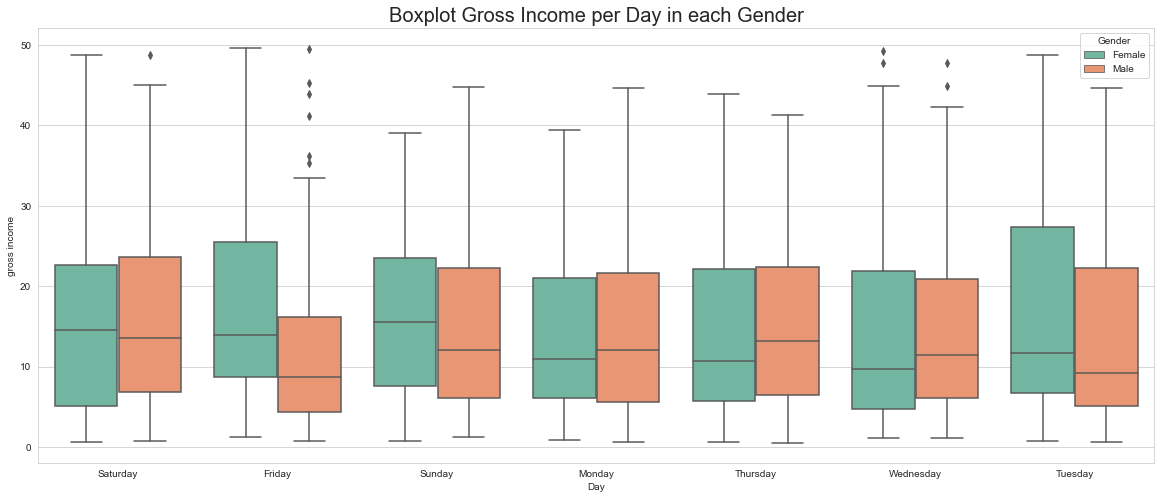

In [28]:
plt.figure(figsize=(20, 8))
plt.grid(True)
ax = sns.boxplot(x="Day", y="gross income", hue='Gender', data=df, palette="Set2")
plt.title('Boxplot Gross Income per Day in each Gender', fontsize=20)
# plt.savefig('8-bpgivsdayvsgender.png')
plt.show()

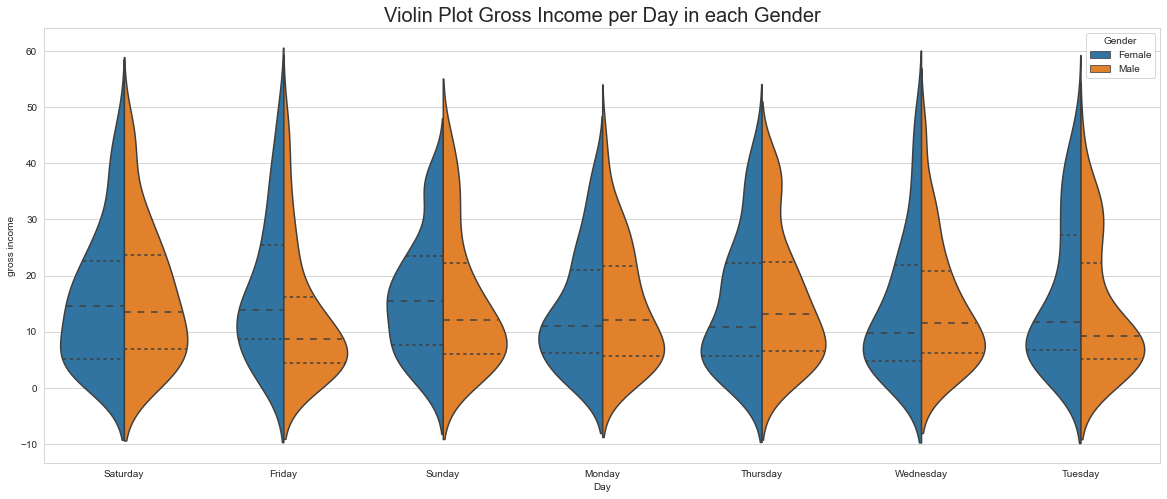

In [29]:
plt.figure(figsize=(20, 8))
sns.violinplot(x="Day", y="gross income",hue="Gender",
               split=True, inner="quart",
               data=df)
plt.title('Violin Plot Gross Income per Day in each Gender', fontsize=20)
# plt.savefig('9-bpgivsdayvsgender.png')
plt.show()

### Grafik Gross Income terhadap Product line per City
- Cabang Yangon:
    - Produk yang paling banyak menghasilkan Gross Income adalah Home and lifestyle
    - Produk yang paling sedikit menghasilkan Gross Income adalah Health and Beauty
- Cabang Naypyitaw:
    - Produk yang paling banyak menghasilkan Gross Income adalah Food and Beverages
    - Produk yang paling sedikit menghasilkan Gross Income adalah Home and lifestyle
- Cabang Mandalay:
    - Produk yang paling banyak menghasilkan Gross Income adalah Health and Beauty dan Sports and travel
    - Produk yang paling sedikit menghasilkan Gross Income adalah Food and Beverages
    
- Saran
    - Rak yang health and beauty dekat dengan Home and lifestyle
    - Memberi diskon atau promo untuk produk Health and Beauty

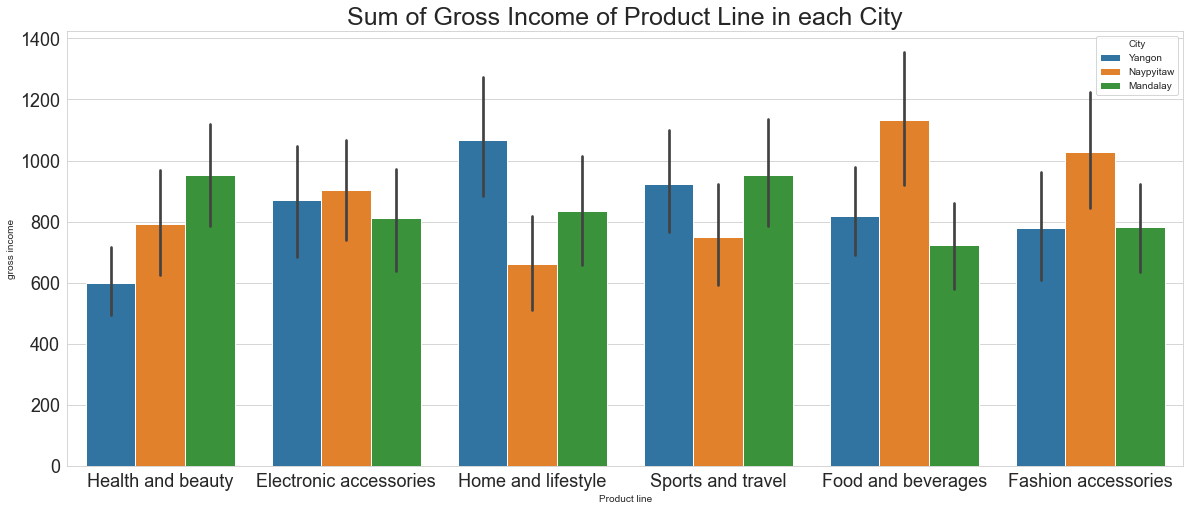

In [30]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x="Product line", y="gross income", hue="City", estimator=sum, data=df)
plt.title('Sum of Gross Income of Product Line in each City', fontsize=25)
plt.tick_params(labelsize=18)
plt.savefig('13-givsprodvscity.png')
plt.show()

### Grafik Gross Income terhadap Gender dan Product line
- <b>Cabang Mandalay</b>:
    - Di Grafik Sebelumnya:
        - Produk yang paling banyak menghasilkan Gross Income adalah Health and Beauty dan Sports and travel
        - Produk yang paling sedikit menghasilkan Gross Income adalah Food and Beverages
    - Female:
        - Produk yang paling banyak menghasilkan Gross Income adalah Food and Beverages
        - Produk yang paling sedikit menghasilkan Gross Income adalah Health and Beauty
    - Male:
        - Produk yang paling banyak menghasilkan Gross Income adalah Health and Beauty
        - Produk yang paling sedikit menghasilkan Gross Income adalah Food and Beverages
- <b>Cabang Naypyitaw</b>:
     - Di Grafik Sebelumnya:
         - Produk yang paling banyak menghasilkan Gross Income adalah Food and Beverages
         - Produk yang paling sedikit menghasilkan Gross Income adalah Home and lifestyle
     - Female:
         - Produk yang paling banyak menghasilkan Gross Income adalah Food and Beverages
         - Produk yang paling sedikit menghasilkan Gross Income adalah Health and Beauty
     - Male:
        - Produk yang paling banyak menghasilkan Gross Income adalah Health and Beauty, Fashion Accessories & Electronic Accessories
        - Produk yang paling sedikit menghasilkan Gross Income adalah Sports and Travel
- <b>Cabang Yangon</b>:
     - Di Grafik Sebelumnya:
        - Produk yang paling banyak menghasilkan Gross Income adalah Home and lifestyle
        - Produk yang paling sedikit menghasilkan Gross Income adalah Health and Beauty
     - Female:
        - Produk yang paling banyak menghasilkan Gross Income adalah Home and Lifestyle
        - Produk yang paling sedikit menghasilkan Gross Income adalah Health and Beauty
     - Male:
        - Produk yang paling banyak menghasilkan Gross Income adalah Food and Beverages
        - Produk yang paling sedikit menghasilkan Gross Income adalah Fashion Accessories
        
Kesimpulan:
    - Dari semua cabang produk Health and Beauty adalah produk yang paling sedikit menghasilkan Gross Income dari Wanita

In [31]:
female = df.pivot_table(index='City', columns=['Gender', 'Product line'],values=['gross income'], aggfunc='sum')['gross income', 'Female']
male = df.pivot_table(index='City', columns=['Gender', 'Product line'],values=['gross income'], aggfunc='sum')['gross income', 'Male']

<Figure size 720x576 with 0 Axes>

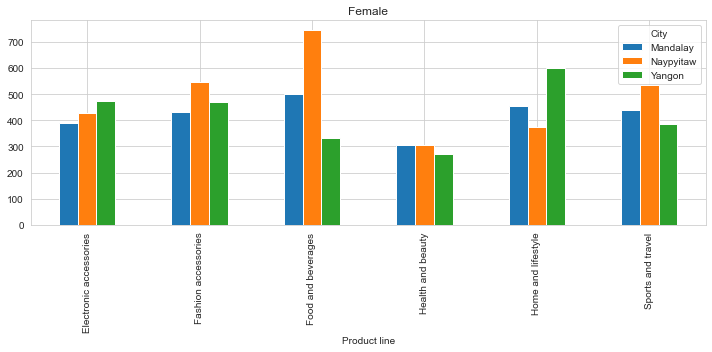

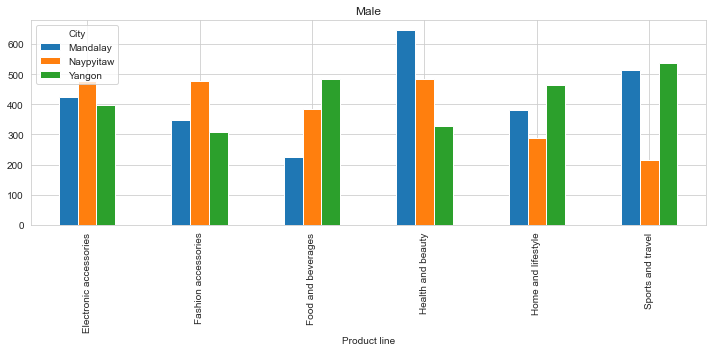

In [32]:
plt.figure(figsize=(10, 8))
female.T.plot(kind='bar', figsize=(10, 5))
plt.title('Female')
plt.tight_layout()
plt.savefig('14-femalevscityvstotal.png', dpi=500)
male.T.plot(kind='bar', figsize=(10, 5))
plt.title('Male')
plt.tight_layout()
plt.savefig('14-malevscityvstotal.png')
plt.show()

### Grafik Boxplot Gross Income per Product line berdasarkan Gender

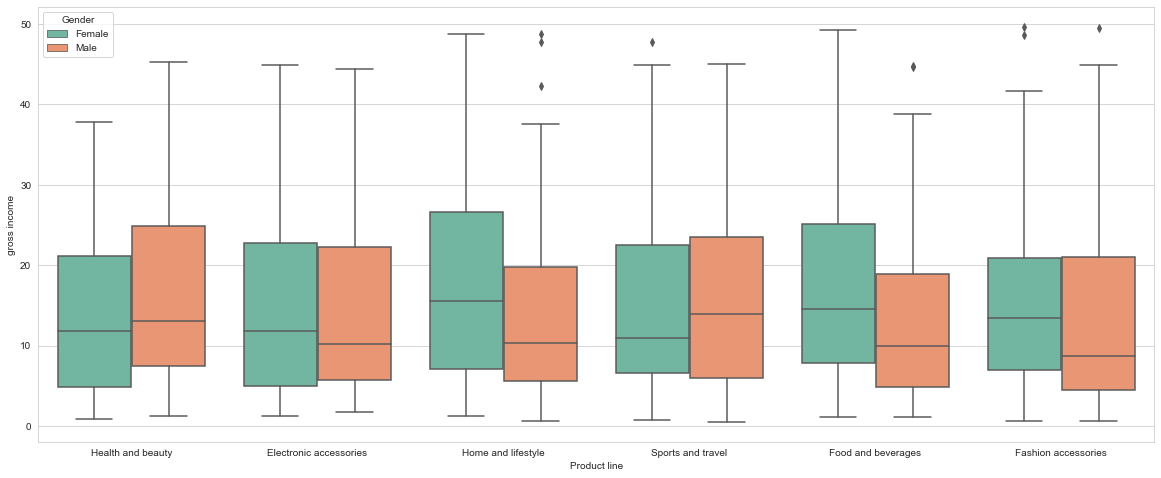

In [33]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x="Product line", y="gross income", hue='Gender',data=df, palette="Set2")

### Grafik Product line terhadap Gross Income pada masing-masing hari
- Health and Beauty menghasilkan Gross income paling banyak: hari Selasa dan paling sedikit: hari Minggu
- Electronic accessories menghasilkan Gross income paling banyak: hari Rabu dan paling sedikit: hari Jumat
- Home and  lifestyle menghasilkan Gross income paling banyak: hari Minggu dan paling sedikit ada: hari Kamis
- Sports and travel menghasilkan Gross income paling banyak: hari Jumat dan paling sedikit: hari Senin
- Food and benerages menghasilkan Gross income paling banyak: hari Rabu dan paling sedikit: hari Jumat
- Fashion accessories menghasilkan Gross income paling banyak hari: Kamis dan paling sedikit hari: Minggu

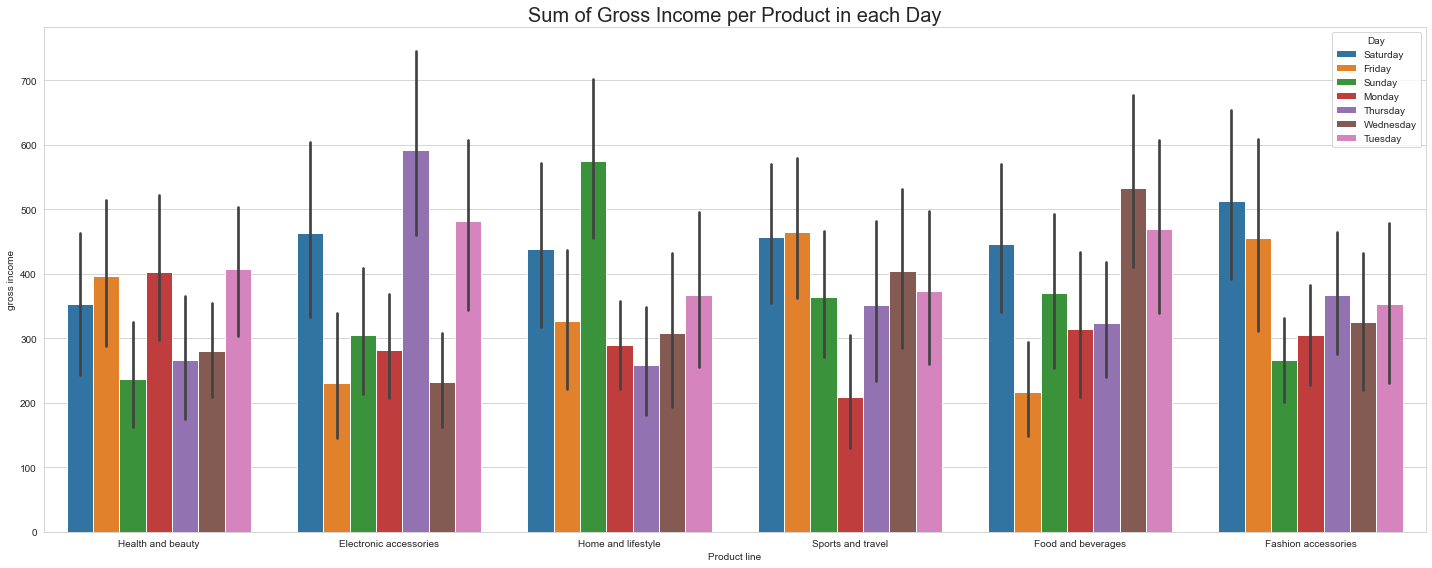

In [34]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x="Product line", y="gross income", hue="Day", estimator=sum, data=df)
plt.title('Sum of Gross Income per Product in each Day', fontsize=20)
plt.tight_layout()
plt.savefig('15-givsprodvsday.png')
plt.show()

### Grafik Jumlah Transaksi di setiap Kota
- Transaksi memuncak pada jam 10:00, 13:00, 15:00 dan 18:00
- Jam-jam minim transaksi jam 12:00 - 14:00 dan diatas jam 19:00

Saran
    - Pada saat transaksi menurun yaitu sekitar jam 15:00 - 18:00 akan dilakukan promosi happy hour seperti promo bundling Health and Beauty

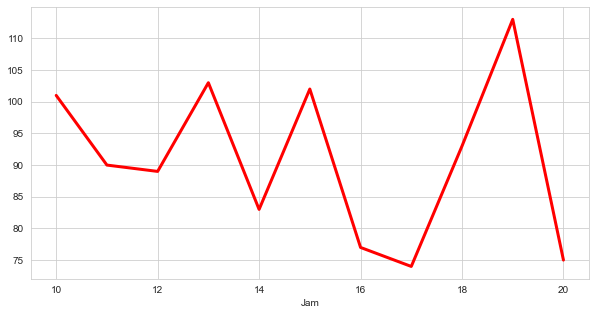

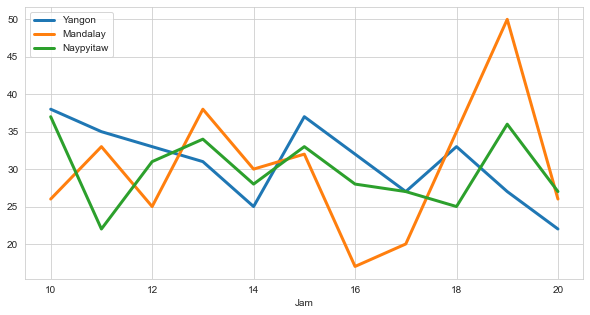

In [35]:
plt.figure(figsize=(10, 5))
df.groupby(['Jam'])['Invoice ID'].count().plot(linewidth=3, color='red')
# plt.savefig('11-jamvstotalpengunjung.png')
plt.figure(figsize=(10, 5))
df.groupby(['City', 'Jam'])['Invoice ID'].count()['Yangon'].plot(linewidth=3)
df.groupby(['City', 'Jam'])['Invoice ID'].count()['Mandalay'].plot(linewidth=3)
df.groupby(['City', 'Jam'])['Invoice ID'].count()['Naypyitaw'].plot(linewidth=3).legend(['Yangon', 'Mandalay', 'Naypyitaw'])
# plt.savefig('11-jamvstotalpengunjungvskota.png')
plt.show()

## <font color='brown'>b) RATING</font> 

## Grafik Pie Rating di setiap Cabang
- Rating terendah ada di cabang Mandalay

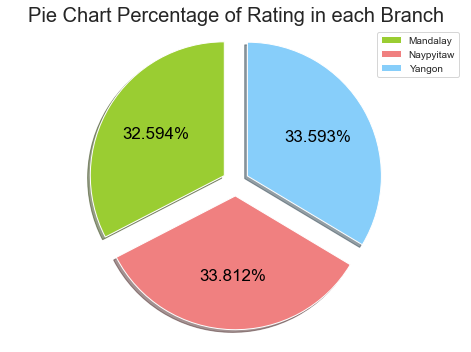

In [36]:
df_rating_per_branch = df.pivot_table(index=['City'], values='Rating', aggfunc=['sum', 'mean', 'median'])
df_rating_per_branch
# df_total_per_branch['Percentage Total'] = (df_total_per_branch['sum']/df_total_per_branch['sum'].sum()) * 100
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(7, 5))
patches = plt.pie(
    df_rating_per_branch['mean','Rating'], 
    colors=colors,
    startangle=90, 
    shadow=True, 
    textprops={
    'size': 17,
    'color': 'black'
    },
    autopct='%.3f%%', 
    explode=(0.1, 0.1, 0.1)
)
plt.legend(patches, labels=df_total_per_branch.index, loc='upper right')
plt.axis('equal')
plt.title('Pie Chart Percentage of Rating in each Branch', fontsize=20)
plt.tight_layout()
plt.show()

In [37]:
df_rating_per_branch = df.pivot_table(index=['City'], values='Rating', aggfunc=['sum', 'mean', 'median'])
df_rating_per_branch[('mean', 'Rating')]

City
Mandalay     6.818072
Naypyitaw    7.072866
Yangon       7.027059
Name: (mean, Rating), dtype: float64

In [38]:
dfdesc = df.groupby(['Day_', 'Day'])['gross income'].describe()
dfdesc['iqr'] = dfdesc['75%'] - dfdesc['25%']
dfdesc

,,count,mean,std,min,25%,50%,75%,max,iqr
Day_,Day,,,,,,,,,
0,Sunday,133.0,15.917613,11.201459,0.7670,6.86100,13.8135,23.28500,44.740,16.42400
1,Monday,125.0,14.437744,10.465359,0.6990,5.95500,11.3060,21.67250,44.600,15.71750
2,Tuesday,158.0,15.516047,12.349153,0.6390,6.29575,10.1480,25.25625,48.685,18.96050
3,Wednesday,143.0,14.562483,11.654047,1.1190,4.98825,9.9820,21.58075,49.260,16.59250
4,Thursday,138.0,15.648464,11.608869,0.5085,5.87250,12.9480,22.53475,43.866,16.66225
5,Friday,139.0,15.048421,12.333647,0.7715,4.83175,11.4980,21.36825,49.650,16.53650
6,Saturday,164.0,16.295241,12.063629,0.6045,5.69425,14.2305,22.78975,48.750,17.09550


## <font color='brown'>c) Mencari Hubungan antarfitur</font> 

### Grafik lmplot dari Unit price dan Rating berdasarkan Gender dan Quantity
- Melihat hubungan Rating terhadap Unit Price per Quantity dan Gender

In [39]:
df.pivot_table(index=['Gender', 'Quantity'], values=['Rating', 'Unit price'], aggfunc=['median', 'sum'])

median               sum           
                Rating Unit price Rating Unit price
Gender Quantity                                    
Female 1          7.30     45.580  325.5    2235.75
       2          6.90     59.640  302.1    2479.32
       3          7.30     57.340  292.3    2366.59
       4          7.10     55.390  379.0    3055.08
       5          7.15     43.640  401.5    2774.35
       6          6.45     57.620  337.8    2882.41
       7          7.10     55.970  339.4    2889.94
       8          7.05     57.190  290.5    2468.66
       9          7.20     54.190  392.3    3122.45
       10         6.60     49.330  428.8    3412.69
Male   1          6.60     56.500  458.7    3899.82
       2          6.70     59.770  322.2    2756.30
       3          7.00     52.750  340.9    2738.71
       4          6.90     56.825  384.2    2956.33
       5          6.95     50.535  322.9    2378.30
       6          7.30     50.865  347.9    2586.67
       7          6.90     58.910  366.7    3050.83
       8          7.20     58.220  308.9    2330.90
       9          7.10     57.380  248.8    2039.82
       10         6.65     61.250  382.3    3247.21

<Figure size 720x576 with 0 Axes>

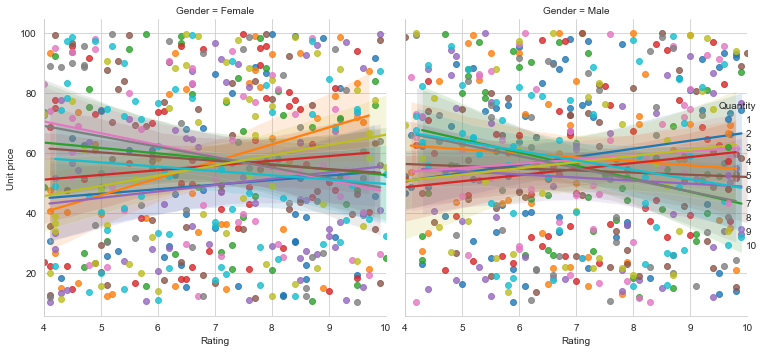

In [40]:
plt.figure(figsize=(10, 8))
sns.lmplot(x='Rating', y='Unit price', col='Gender', data=df, hue='Quantity')
plt.tight_layout()
plt.savefig('16-ratingvsgender.png')
plt.show()

<b>Pendekatan Linear</b>
<br><br>
<b>FEMALE</b>
- Quantity 1, 2, 4, 5, 9: Semakin tinggi Unit Price semakin tinggi Rating
- Quantity 3, 6, 7, 8, 10: Semakin tinggi Unit Price semakin kecil Rating
    
<b>MALE</b>
- Quantity 1, 4, 7, 9: Semakin tinggi Unit Price semakin tinggi Rating
- Quantity 2, 3, 5, 6, 8, 10: Semakin tinggi Unit Price semakin kecil Rating

<Figure size 720x576 with 0 Axes>

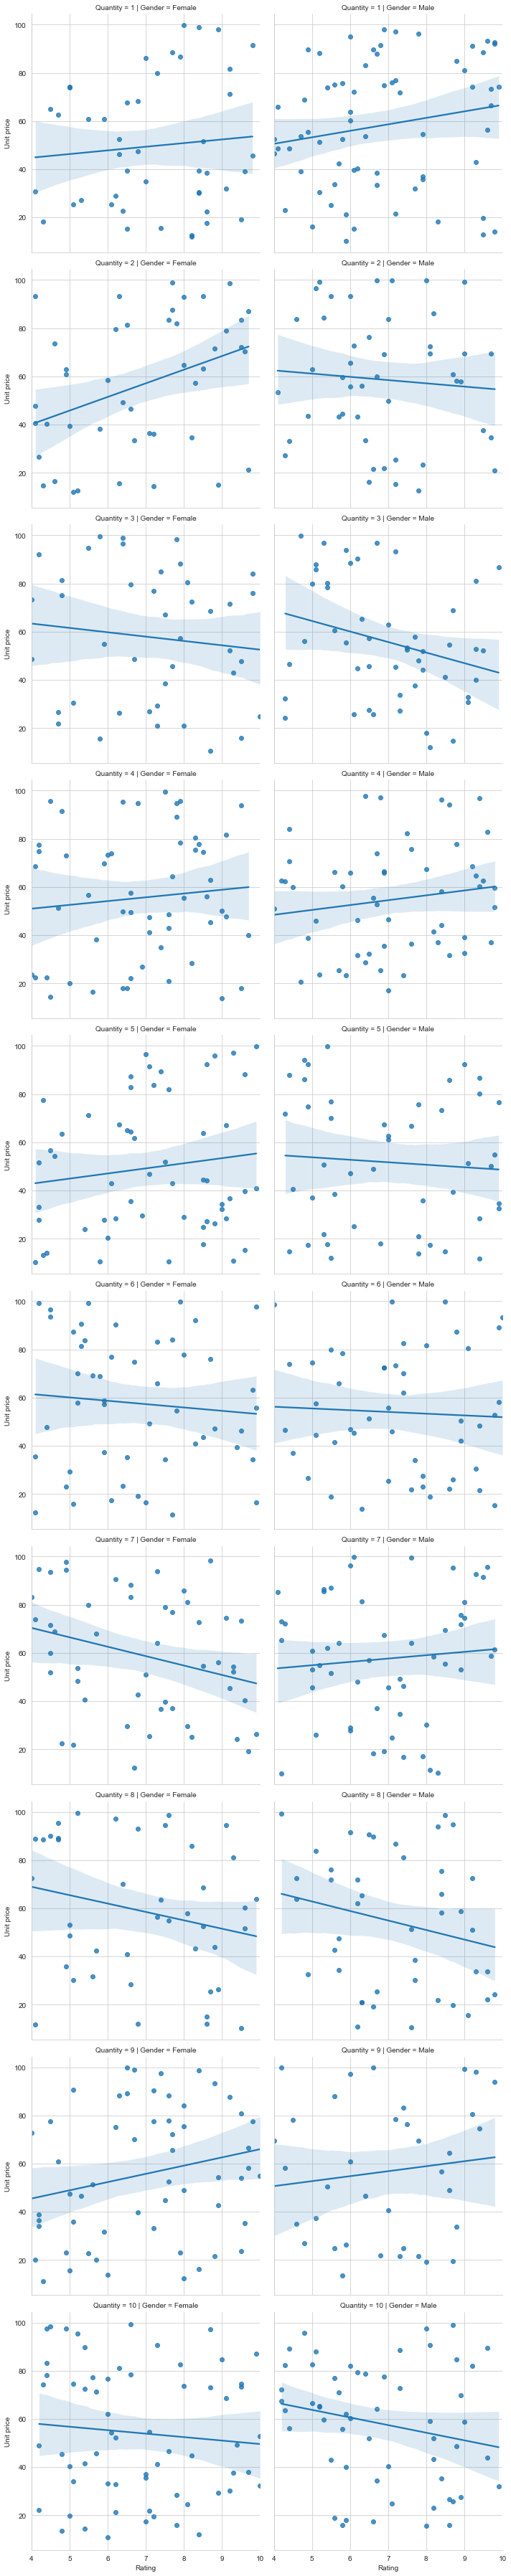

In [41]:
plt.figure(figsize=(10, 8))
sns.lmplot(x='Rating', y='Unit price', col='Gender', row='Quantity', data=df)
plt.tight_layout()
plt.savefig('17-genvsqualvscol.png')
plt.show()

## <font color='brown'>d) PAYMENT</font>

### Grafik lmplot Rating dan Gross Income berdasarkan Payment dan Gender

<Figure size 720x576 with 0 Axes>

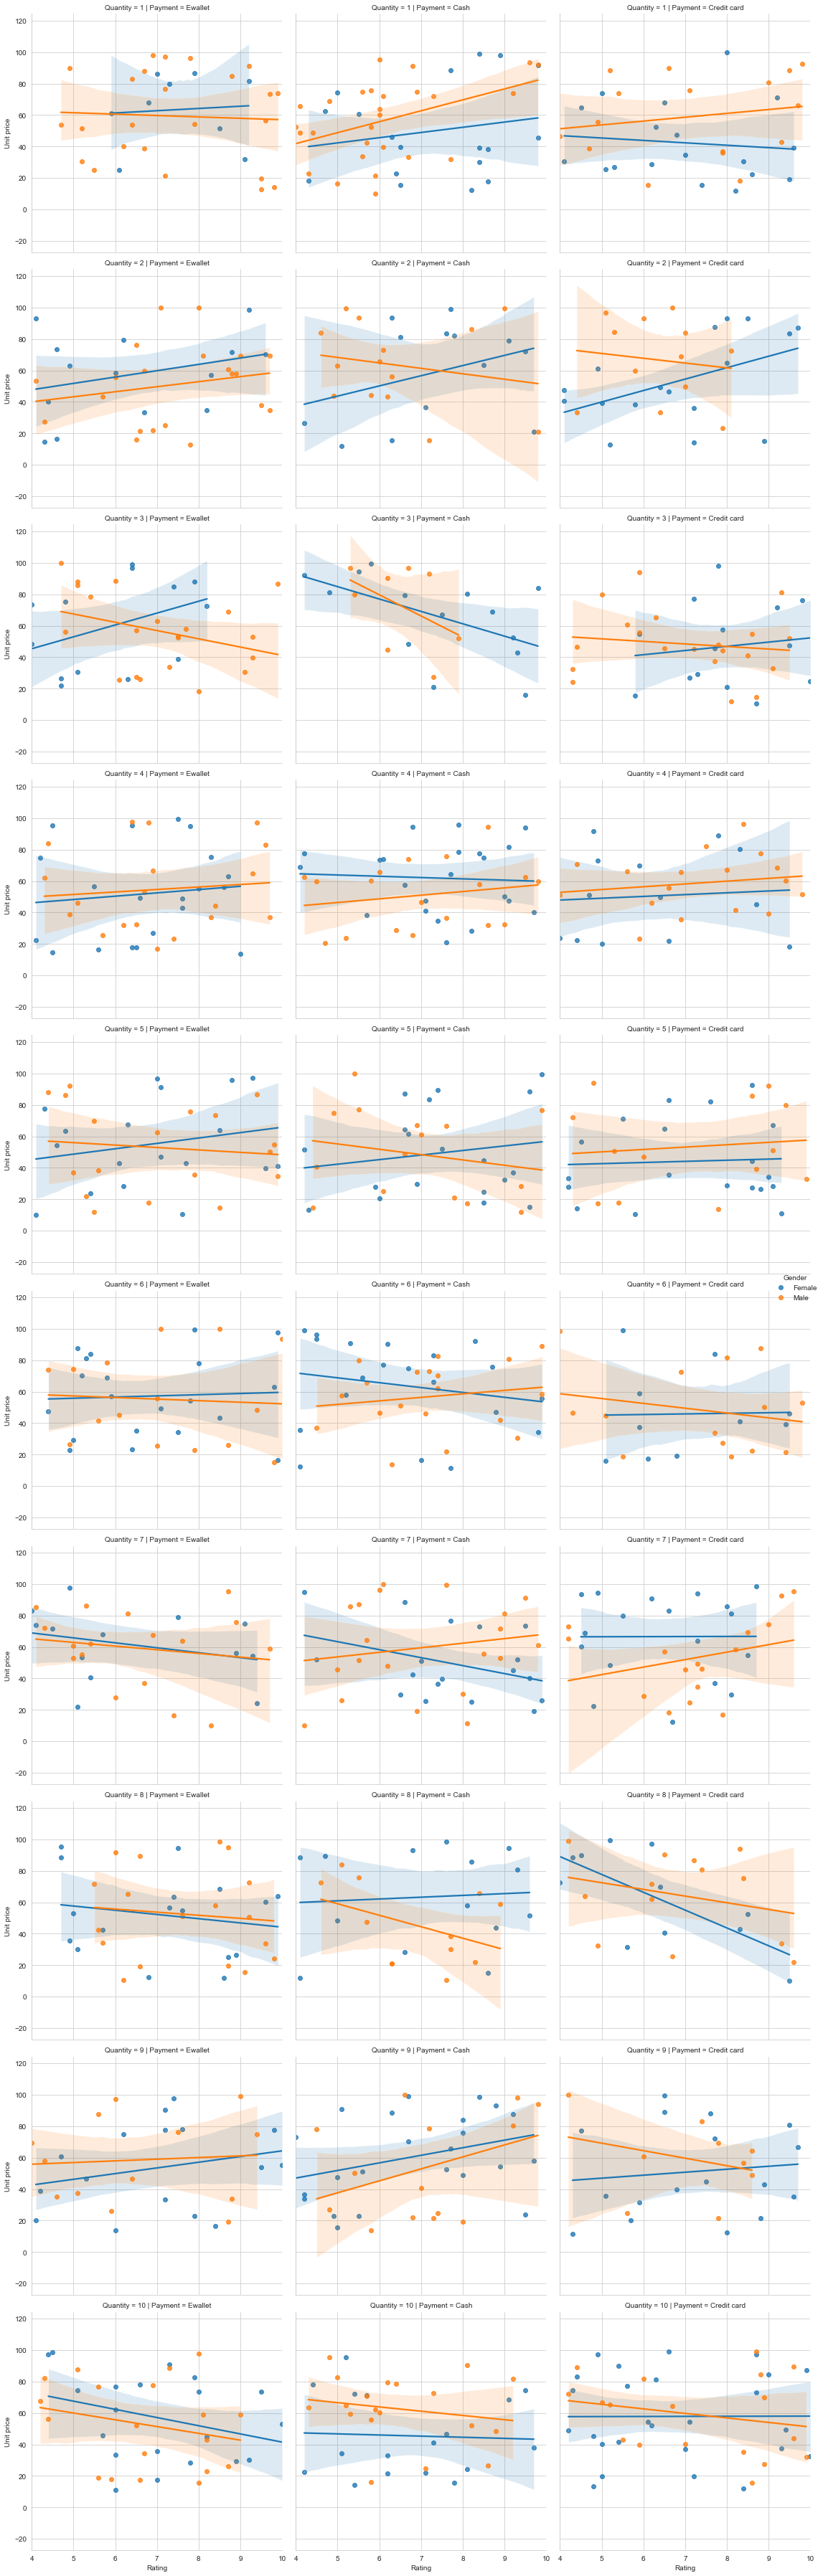

In [42]:
plt.figure(figsize=(10, 8))
sns.lmplot(x='Rating', y='Unit price', col='Payment', row='Quantity', hue='Gender', data=df)
plt.tight_layout()
plt.savefig('18-paymentvsquant.png')
plt.show()

<Figure size 720x576 with 0 Axes>

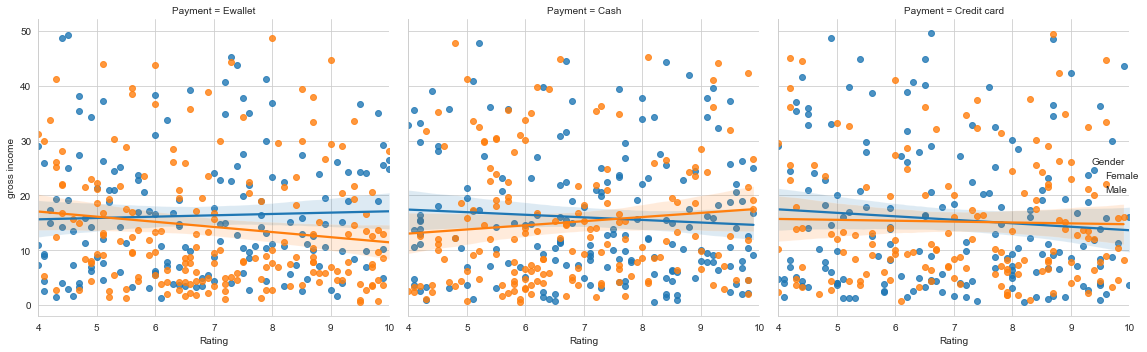

In [43]:
plt.figure(figsize=(10, 8))
sns.lmplot(x='Rating', y='gross income', col='Payment', data=df, hue='Gender')
plt.tight_layout()
plt.savefig('19-payment.png')
plt.show()

In [44]:
df.groupby(['City', 'Customer type', 'Payment', 'Gender']).agg({'gross income': ['min', 'max', 'mean', 'median', 'sum']})

gross income                      \
                                                    min      max       mean   
City      Customer type Payment     Gender                                    
Mandalay  Member        Cash        Female       1.9740  39.7755  15.023700   
                                    Male         1.6815  41.2900  15.352107   
                        Credit card Female       0.9575  42.3150  16.289629   
                                    Male         1.9505  44.9820  18.086893   
                        Ewallet     Female       1.6490  37.7960  13.314500   
                                    Male         2.5680  43.7490  14.270083   
          Normal        Cash        Female       0.8875  37.8405  16.371714   
                                    Male         1.6760  39.6950  14.447310   
                        Credit card Female       1.2725  48.6850  15.307229   
                                    Male         2.2230  39.6640  15.199227   
                        Ewallet     Female       1.4760  48.6900  16.640860   
                                    Male         1.6160  43.9350  12.936103   
Naypyitaw Member        Cash        Female       0.6270  44.5365  16.797806   
                                    Male         0.5085  45.2500  15.524607   
                        Credit card Female       1.2730  49.6500  17.865800   
                                    Male         0.7715  40.9750  13.011260   
                        Ewallet     Female       1.5950  49.2600  16.804300   
                                    Male         0.6990  41.1700  14.924900   
          Normal        Cash        Female       1.5120  47.7200  16.345786   
                                    Male         0.8140  47.7900  17.472800   
                        Credit card Female       1.1190  29.7570  12.109500   
                                    Male         1.7945  44.7400  14.198219   
                        Ewallet     Female       3.2900  36.7800  17.949100   
                                    Male         0.6390  48.7500  16.708048   
Yangon    Member        Cash        Female       0.9165  44.3970  15.534338   
                                    Male         1.5920  36.3900  14.266614   
                        Credit card Female       1.5310  40.1445  14.045750   
                                    Male         1.7910  34.6720  15.274241   
                        Ewallet     Female       2.6725  45.3250  17.678269   
                                    Male         0.9850  44.3350  14.684153   
          Normal        Cash        Female       0.7670  37.2480  15.160300   
                                    Male         1.0660  44.1405  13.365190   
                        Credit card Female       0.6045  40.6050  16.200278   
                                    Male         0.9140  49.4900  14.809464   
                        Ewallet     Female       1.2645  37.2200  15.568776   
                                    Male         1.2500  35.8400  12.366571   

                                                                
                                              median       sum  
City      Customer type Payment     Gender                      
Mandalay  Member        Cash        Female  10.71500  375.5925  
                                    Male    13.65900  429.8590  
                        Credit card Female  15.92100  570.1370  
                                    Male    15.93100  506.4330  
                        Ewallet     Female  10.12800  332.8625  
                                    Male     8.32050  342.4820  
          Normal        Cash        Female  17.24500  458.4080  
                                    Male    11.10600  418.9720  
                        Credit card Female   7.03575  367.3735  
                                    Male     7.10100  334.3830  
                        Ewallet     Female  14.50200  416.0215  
                                    Male     9.9890

In [45]:
# Total, Customer type
df.groupby(['Branch', 'City', 'Customer type'])['gross income'].sum()

# Customer type: Member menghasilkan gross income yang lebih besar daripada Customer non-Member
# Perbedaan signifikan pendapatan jenis member dan non-Member ada di cabang Naypyitaw
# Di Naypyitaw harus lebih gencar menawarkan membership kepada pengunjung atau customer

Branch  City       Customer type
A       Yangon     Member           2554.1655
                   Normal           2502.9950
B       Mandalay   Member           2557.3660
                   Normal           2499.6660
C       Naypyitaw  Member           2708.6325
                   Normal           2556.5440
Name: gross income, dtype: float64

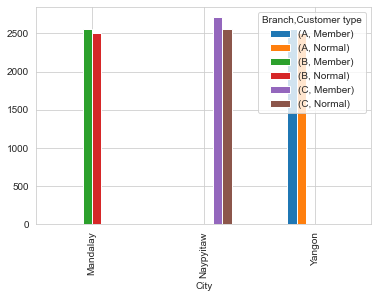

In [46]:
df.groupby(['Branch', 'City', 'Customer type'])['gross income'].sum().unstack(['Branch', 'Customer type'])\
        .plot(kind='bar')
plt.show()


In [47]:
# Rating
df.groupby(['Branch', 'City'])['Rating'].mean()

# Rata-rata rating belum memuaskan untuk semua cabang sehingga harus dilakukan training hospitality kepada semua pegawai
# Buat survey level kepuasan pelanggan dari segi customer service, teknis, lokasi, variasi produk, kebersihan, kenyamanan belanja
# sehingga bisa mengetahui yang harus diperbaiki agar ratingnya bisa naik

Branch  City     
A       Yangon       7.027059
B       Mandalay     6.818072
C       Naypyitaw    7.072866
Name: Rating, dtype: float64

In [48]:
def highlightMax(s):
    isMax = s == s.max()
    return ['background-color: red; color:white' if v else '' for v in isMax] #Maximum: Red

def highlightMin(s):
    isMin = s == s.min()
    return ['background-color: pink' if v else '' for v in isMin] #Minimum: Pink

In [49]:
total_dan_gross_income = df.pivot_table(index=['Branch', 'City', 'Month_', 'Month'], values=['Total', 'gross income'], aggfunc='sum')
total_dan_gross_income.style.apply(highlightMax).apply(highlightMin).highlight_null(null_color='red')

In [50]:
df.groupby('City')['Invoice ID'].count()

City
Mandalay     332
Naypyitaw    328
Yangon       340
Name: Invoice ID, dtype: int64

In [51]:
kesimpulan = df.groupby(['City', 'Gender', 'Product line']).sum().reset_index()
kesimpulan

,City,Gender,Product line,Tanggal,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
0,Mandalay,Female,Electronic accessories,415,1334.98,156,388.8815,8166.5115,7777.63,133.333333,388.8815,198.9
1,Mandalay,Female,Fashion accessories,531,1654.48,177,432.4520,9081.4920,8649.04,157.142857,432.4520,220.5
2,Mandalay,Female,Food and beverages,423,1760.05,169,500.4760,10509.9960,10009.52,138.095238,500.4760,212.4
3,Mandalay,Female,Health and beauty,311,1004.12,112,304.7785,6400.3485,6095.57,95.238095,304.7785,145.8
4,Mandalay,Female,Home and lifestyle,248,1333.92,147,455.1015,9557.1315,9102.03,104.761905,455.1015,145.3
5,Mandalay,Female,Sports and travel,467,1687.69,150,438.7055,9212.8155,8774.11,142.857143,438.7055,191.1
6,Mandalay,Male,Electronic accessories,421,1407.00,160,423.0920,8884.9320,8461.84,128.571429,423.0920,192.5
7,Mandalay,Male,Fashion accessories,450,1745.84,120,349.1345,7331.8245,6982.69,138.095238,349.1345,196.3
8,Mandalay,Male,Food and beverages,309,1016.95,101,224.0425,4704.8925,4480.85,100.000000,224.0425,137.3
9,Mandalay,Male,Health and beauty,619,2079.72,208,646.6815,13580.3115,12933.63,157.142857,646.6815,230.5


In [52]:
Mandalay = kesimpulan[kesimpulan['City'] == 'Mandalay'].set_index(['City', 'Gender', 'Product line'])
Mandalay = Mandalay.drop(columns=['gross margin percentage', 'Tanggal', 'Tax 5%', 'Rating'])
Mandalay.style.apply(highlightMax).apply(highlightMin).highlight_null(null_color='red')

In [53]:
Yangon = kesimpulan[kesimpulan['City'] == 'Yangon'].set_index(['City', 'Gender', 'Product line'])
Yangon = Yangon.drop(columns=['gross margin percentage', 'Tanggal', 'Tax 5%', 'Rating'])
Yangon.style.apply(highlightMax).apply(highlightMin).highlight_null(null_color='red')

In [54]:
Naypyitaw = kesimpulan[kesimpulan['City'] == 'Naypyitaw'].set_index(['City', 'Gender', 'Product line'])
Naypyitaw = Naypyitaw.drop(columns=['gross margin percentage', 'Tanggal', 'Tax 5%', 'Rating'])
Naypyitaw.style.apply(highlightMax).apply(highlightMin).highlight_null(null_color='red')

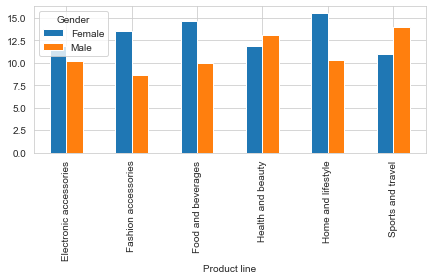

In [55]:
df.groupby(['Gender', 'Product line'])['gross income'].median().unstack('Gender').plot.bar()
plt.tight_layout()
# df.pivot_table(index=['Gender', 'Product line'])
plt.savefig('15-prodvsgender.png')

plt.show()

## Kesimpulan dan Saran:
- Cabang Mandalay:
    - Promosi lebih dikhususkan pada customer pria untuk kategori Food and Beverages
    - Promosi lebih dikhususkan pada customer wanita untuk kategori Health and Beauty
    - Promo happy hour dapat dilakukan setiap jam 16:00
- Cabang Yangon
    - Promosi lebih dikhususkan pada customer wanita untuk kategori Health and Beauty
    - Promosi lebih dikhususkan pada customer pria untuk kategori Fashion Accessories
    - Promo happy hour dapat dilakukan setiap jam jam 11:00 dan 12:00
- Cabang Naypyitaw
    - Promosi lebih dikhususkan pada customer pria untuk kategori Sports and travel
    - Promosi lebih dikhususkan pada customer pria untuk kategori Health and Beauty
    - Di Naypyitaw harus lebih gencar menawarkan membership kepada pengunjung atau customer
    - Promosi sebaiknya dilakukan pada jam 16:00 untuk meningkatkan jumlah transaksi
    - Promo happy hour dapat dilakukan setiap jam 20:00
    
    
- Rata-rata rating belum memuaskan untuk semua cabang sehingga harus dilakukan training hospitality kepada semua pegawai
- Membuat survey level kepuasan pelanggan dari segi customer service, teknis, lokasi, variasi produk, kebersihan, kenyamanan belanja sehingga bisa mengetahui yang harus diperbaiki agar ratingnya bisa naik
- Health and Beauty menghasilkan Gross income paling banyak: hari Selasa dan paling sedikit: hari Minggu
- Electronic accessories menghasilkan Gross income paling banyak: hari Rabu dan paling sedikit: hari Jumat
- Home and lifestyle menghasilkan Gross income paling banyak: hari Minggu dan paling sedikit ada: hari Kamis
- Sports and travel menghasilkan Gross income paling banyak: hari Jumat dan paling sedikit: hari Senin
- Food and benerages menghasilkan Gross income paling banyak: hari Rabu dan paling sedikit: hari Jumat
- Fashion accessories menghasilkan Gross income paling banyak hari: Kamis dan paling sedikit hari: Minggu